#Monthly BZCAT comparison 
Read in the "bzcat_summary" files generated by the association analysis for each month, and for the 6-year model. Those files, indexed by the name, have the association info, the name of the 6-year source, and TS of the fit. 

In [15]:
%matplotlib inline
os.chdir(os.path.expandvars('$FERMI/skymodels/P301_monthly'))
import glob, pickle
ff = sorted(glob.glob('month*/plots/associations/bzcat_summary*.csv'));
print 'found %d months' %len(ff)

found 35 months


Compile all the monthly files, make a list of the unique names.

In [17]:
ffs = ff[:30] #restrict
monthlist = [int(f[5:7]) for f in ffs]; 
bzm = [pd.read_csv(f, index_col=0) for f in ffs]
bznames=[] 
for bz in bzm:
    bznames.append(list(bz.index))
sets = map(set, bznames)
# make a combined table of bzcat associations
a = sets[0]
for b in sets[1:]:
    a = a.union(b)
bznames = sorted(a); 
print 'Found %d unique names in %d months' % (len(bznames),len(monthlist)) 
np.asarray(bzm[0].columns, str)

Found 293 unique names in 30 months


array(['ang', 'dec', 'deltats', 'locqual', 'ra', 'sname', 'ts', 'type'], 
      dtype='|S7')

Get the list of associations from the 6-year run.

Compare it with the set of names from the monthly analyses

Idealy, there should be no overlap, since the 6-year sources are input to the source finding procedure. Two things can happen:
1. The 6-year source was discarded by mistake
2. The new source is close enough to get associated. 

In [18]:
bz6 = pd.read_csv(os.path.expandvars(
        '$FERMI/skymodels/P301_6years/uw972/plots/associations/bzcat_summary.csv'),
                  index_col=0)
bz6names=set(bz6.index)
insix =set(bznames).intersection(bz6names)
print '%d monthly names are in the 6-year list of %d names'\
    % (len(insix), len(bznames))

142 monthly names are in the 6-year list of 293 names


Make a DataFrame with the bzname index, and monthly info

In [19]:
from skymaps import SkyDir, Band
bb = dict()
for bzname in bznames:
    tss = [0]*len(bzm)
    for i,tlist in enumerate(bzm):
        if bzname not in tlist.index: continue
        j = list(tlist.index).index(bzname)
        tss[i] = round(tlist.ts[j],1)
    bb[bzname] = dict(ts=tss,)
df = pd.DataFrame(bb).T
df.index.name='bzcat_name'
df['tsmax'] = [max(ts) for ts in df.ts]
df['months']= [sum(np.array(ts)>0) for ts in df.ts]
df['type'] = [name[3] for name in df.index]
df['ts6'] = bz6.ts.round(1)
df['y6name'] = bz6.sname
df['ra']  = bz6.ra
df['dec'] = bz6.dec
df['roi'] = [-1 if np.isnan(ra) else Band(12).index(SkyDir(ra,dec)) for ra,dec in zip(df.ra,df.dec)]
df['notin6y'] = [not isinstance(x, str) for x in df.y6name]; 
df.ix[0]

ts         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.5...
tsmax                                                    7.5
months                                                     1
type                                                       B
ts6                                                     33.6
y6name                                              P86Y0062
ra                                                   3.48483
dec                                                 19.17833
roi                                                     1430
notin6y                                                False
Name: 5BZBJ0013+1910, dtype: object

Examine the list of new associations

In [39]:
df.ix[df.notin6y & (df.tsmax>10) & (df.months>1)]['ts tsmax months type'.split()]

,ts,tsmax,months,type
bzcat_name,,,,
5BZBJ1110+1704,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24.6,2,B
5BZBJ1925+2106,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20.8,2,B
5BZQJ0448-3659,"[0, 0, 0, 0, 0, 0, 0, 10.7, 0, 0, 0, 0, 0, 0, ...",10.7,2,Q
5BZQJ0750+1021,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17.3,2,Q
5BZQJ1423-7829,"[0, 0, 0, 0, 0, 20.0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20.0,2,Q
5BZQJ1854+7351,"[0, 0, 0, 0, 0, 0, 0, 0, 12.1, 0, 0, 0, 0, 0, ...",12.1,2,Q
5BZQJ2050+3127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 21.8, 0, 0, 0, 0, ...",21.8,2,Q
5BZQJ2145-3142,"[0, 0, 0, 0, 17.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17.0,2,Q
5BZUJ2208+6519,"[28.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.2, 0, ...",28.1,4,U


In [38]:
h,b = np.histogram(df.months, range(10))
dict(zip(b,h))

{0: 0, 1: 253, 2: 25, 3: 7, 4: 3, 5: 4, 6: 0, 7: 0, 8: 0}

In [31]:
nm =[sum( [ts[m]>0 for ts in df.ts]) for m in range(len(monthlist))]; 
ngood=[sum( [((ts[m]>0) & b) for ts,b in zip(df.ts,df.notin6y)]) for m in range(len(monthlist))]; 
#nm,ngood
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(monthlist,[len(bz) for bz in bzm],  'o', label='all BZCAT associations')
ax.plot(monthlist, ngood, 'sr', label='new associations')
plt.setp(ax, xlim=(0.5, monthlist[-1]+0.5), xlabel='month number', ylim=(0,None),ylabel='BZCAT sources found')
ax.grid(True, alpha=0.5)
ax.legend(loc='upper left')

In [24]:
types = set(list(df.type))
tc = [sum(df.type==type) for type in types]
pd.DataFrame(dict(zip(types, tc)), index=['number']).T

,number
B,99
G,18
Q,149
U,27


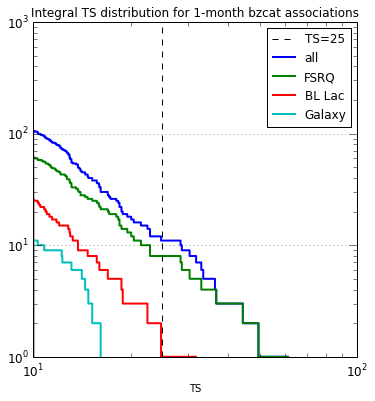

In [25]:
# make an integral logTS plot for the new 1-month guys
dfnew = df[df.notin6y]
fig, ax = plt.subplots(figsize=(6,6))
tsmax=100
dom = np.logspace(1,np.log10(tsmax),500)
hist_kw = dict( cumulative=-1, lw=2, histtype='step', log=True)
ax.axvline(25, color='k', ls='--', label='TS=25')

ax.hist(dfnew.tsmax[dfnew.months==1], dom, label='all', **hist_kw );

for type,label in zip('QBG', ['FSRQ', 'BL Lac', 'Galaxy']):
    sel = (dfnew.months==1)& (dfnew.type==type)
    if sum(sel)>0:
        try:
            ax.hist(dfnew.tsmax[sel], dom, label=label, **hist_kw)
        except: pass

plt.setp(ax, xscale='log', xlabel='TS', ylim=(1,None), xlim=(10, tsmax),
        title='Integral TS distribution for 1-month bzcat associations')
ax.grid(True, alpha=0.8);

leg=ax.legend()
for pbox in leg.get_patches():
    pbox._height=0; pbox._y=5

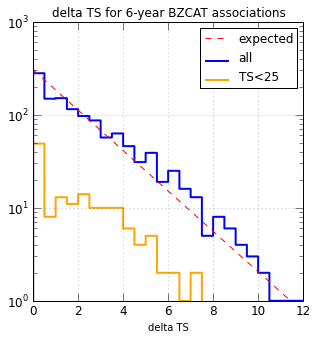

In [26]:

def delta_ts_figure(df,  title='', ax=None,):
    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
    else: fig = ax.figure
    deltats=df.deltats
    hist_kw=dict(log=True, histtype='step', lw=2)
    binsize=0.5; maxts=12
    bins = np.linspace(0,maxts,maxts/binsize+1)
    ax.hist( deltats.clip(0,12), bins,   label='all', **hist_kw)
    ax.hist( deltats[df.ts<25].clip(0,12), bins,  color='orange',
            label='TS<25',  **hist_kw)
    plt.setp(ax, xlabel='delta TS', ylim=(1,1000), title=title)
    ax.plot(bins, len(deltats)*binsize*0.5*np.exp(-bins/2),ls='--', color='r', label='expected')
    ax.grid(True, alpha=0.5); 
    leg=ax.legend()
    for box in leg.get_patches():
        box._height=0; box._y=0.5
    return fig
delta_ts_figure(bz6,'delta TS for 6-year BZCAT associations' );
 

In [28]:
from uw.like2.analyze import associations; reload(associations)
a = associations.ExtAssociations('month01')

loading sources.pickle
using associations found in sourceinfo
associated: 534/1602


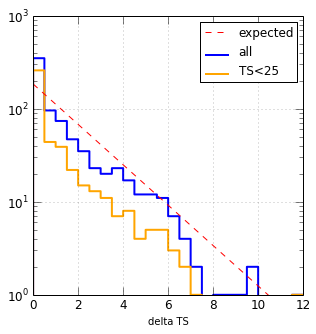

In [29]:
a.delta_ts_figure(df=a.df[a.df.locqual<8]);

In [30]:
a.df.ix[a.df.locqual>4]['ts adeltats locqual'.split()]

,ts,adeltats,locqual
name,,,
P86Y0123,13.68894,1.408242,4.04
Sh01-1282,9.528081,1.191252,4.13
P86Y0416,11.60632,-4.514870,4.12
P86Y0597,5.4285,-1.023711,15.29
P86Y0625,13.86299,0.696059,5.16
P86Y0794,18.17047,-0.282175,4.55
P86Y0843,13.3136,1.169613,4.99
P86Y0941,12.03744,-0.352987,5.29
P86Y1058,17.32649,-4.347352,5.58
